In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc
from sklearn.pipeline import make_pipeline
import seaborn as sns

In [2]:
csv_url = "https://raw.githubusercontent.com/HongjinZhu/Data-Analysis-Project2/main/movieReplicationSet.csv"
df = pd.read_csv(csv_url)

def impute_missing_values(df):
    # Replace non-numeric entries with NaN
    df = df.apply(pd.to_numeric, errors='coerce')

    # Calculate column means (average rating per movie)
    col_means = df.mean(axis=0)

    # Calculate row means (average rating per user)
    row_means = df.mean(axis=1)

    # Calculate the global mean
    global_mean = df.stack().mean()

    # Function to apply imputation with fallback
    def blend_impute_with_fallback(row):
        imputed_row = row.copy()
        for col in df.columns:
            if pd.isna(row[col]):
                row_mean = row_means[row.name]
                col_mean = col_means[col]

                # Check if both row mean and column mean are available
                if pd.notna(row_mean) and pd.notna(col_mean):
                    imputed_value = 0.5 * row_mean + 0.5 * col_mean
                else:
                    # Fallback to the global mean if either is NaN
                    imputed_value = global_mean

                imputed_row[col] = imputed_value
        return imputed_row

    # Apply the imputation to each row
    imputed_df = df.apply(blend_impute_with_fallback, axis=1)
    return imputed_df

movie_ratings = df.iloc[:, :400]

# Impute missing values in the movie ratings
imputed_movie_ratings = impute_missing_values(movie_ratings)
imputed_movie_ratings.head()

,The Life of David Gale (2003),Wing Commander (1999),Django Unchained (2012),Alien (1979),Indiana Jones and the Last Crusade (1989),Snatch (2000),Rambo: First Blood Part II (1985),Fargo (1996),Let the Right One In (2008),Black Swan (2010),...,X-Men 2 (2003),The Usual Suspects (1995),The Mask (1994),Jaws (1975),Harry Potter and the Chamber of Secrets (2002),Patton (1970),Anaconda (1997),Twister (1996),MacArthur (1977),Look Who's Talking (1989)
0,2.447086,2.381992,4.000000,2.725235,3.000000,2.670257,2.554121,2.821232,2.619604,2.827211,...,2.828460,2.921947,2.650951,4.000000,0.500000,2.510773,2.519156,2.572578,2.428806,2.540410
1,2.439294,2.374200,1.500000,2.717443,2.752945,2.662464,2.546329,2.813440,2.611812,2.819419,...,2.820668,2.914154,2.643159,2.673112,4.000000,2.502981,2.511364,2.564786,2.421013,2.532618
2,2.733065,2.667971,3.234118,3.011214,3.046716,2.956236,2.840100,3.107211,2.905583,3.113190,...,3.114439,3.207926,2.936930,2.966883,3.500000,2.796752,2.805135,2.858557,2.714784,2.826389
3,2.282975,2.217880,2.000000,2.561123,3.000000,2.506145,2.390009,2.657120,2.455492,4.000000,...,2.664348,3.000000,2.486840,2.516793,2.500000,2.346661,2.355044,2.408466,2.264694,2.376299
4,2.209132,2.144038,3.500000,2.487281,0.500000,2.432303,0.500000,1.000000,2.381650,0.000000,...,2.500000,2.683993,3.000000,2.442950,2.769704,2.272819,2.281202,1.500000,2.190852,2.302456


#### 3)
Pick 30 movies in the middle of the COD range, as identified by question 1 (that were not used in question 2). Now build a regularized regression model with the ratings from 10 other movies (picked randomly, or deliberately by you) as an input. Please use ridge regression, and make sure to do suitable hyperparameter tuning. Also make sure to report the RMSE for each of these 30 movies in a table, after doing an 80/20 train/test split. Comment on the hyperparameters you use and betas you find by doing so.

We first exclude the movies with top and bottom COD ranges, randomly pick 30 movies in the remaining movies with COD in the middle (each row forms a target y), and 10 other movies as input. Then, we do a train test split and use the grid search method to tune the hyperparameter in the Ridge regression model. After that, we fit the test set into the best model. Here we regard the 10 movies as features of the users and use the 10 features to predict the ratings each user will give to a new movie. The amount of data is small in this dataset, so for hyperparameter tuning, we use the grid search method to get a more reliable best model to prevent overfitting. In the table, we see movies, RMSE, best hyperparameter, and coefficients. Here we see that some of the betas are approaching 0, meaning that the ratings of that movie have little effect on predicting the ratings of the target movie. In real life, we suppose these two movies may be in different genres. We observe a relatively large hyperparameter, meaning that the regularization term played a crucial role in the model.

In [3]:
bottom_10_indices = [80, 95, 9, 55, 190, 319, 292, 41, 14, 248]
top_10_indices = [300, 334, 287, 282, 240, 249, 395, 377, 208, 203]

# select 30 random movies in the middle
exclude_columns = imputed_movie_ratings.columns[bottom_10_indices + top_10_indices]
available_columns = imputed_movie_ratings.iloc[:, :400].columns.difference(exclude_columns)
selected_columns = np.random.choice(available_columns, size=30, replace=False)
selected_movies_df = imputed_movie_ratings[selected_columns]

In [4]:
# pick 10 other movies as input
col_pool = available_columns.difference(selected_columns)
other_movies_indices = np.random.choice(col_pool, size=10, replace=False)
other_movies_data = imputed_movie_ratings[other_movies_indices]
input_data = other_movies_data

In [5]:
RMSE = []
alphas = []
betas = []
X = input_data.values

for m in selected_movies_df:
  y = selected_movies_df[m].values
  # train test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # ridge regression with hyperparameter tuning
  param_grid = {'alpha': [1e-2, 1e-1, 1, 10, 100, 1000]}
  grid_search = GridSearchCV(Ridge(), param_grid, scoring='neg_mean_squared_error', cv=10)
  grid_search.fit(X_train, y_train)
  best_alpha = grid_search.best_params_['alpha']
  best_model = grid_search.best_estimator_
  beta = best_model.coef_
  formatted_betas = [f"{beta:.2f}" for _, beta in enumerate(beta)]
  # print(beta)

  # evaluate the model
  predictions = best_model.predict(X_test)
  rmse = np.sqrt(mean_squared_error(y_test, predictions))
  RMSE.append(rmse)
  alphas.append(best_alpha)
  betas.append(formatted_betas)

# display the RMSE for each of the 30 movies
results_r = pd.DataFrame({'Movie': selected_movies_df.columns, 'RMSE': RMSE, 'best hyper': alphas, 'coef': betas})
results_r

,Movie,RMSE,best hyper,coef
0,Red Sonja (1985),0.226167,10,"[0.03, 0.07, 0.13, 0.12, 0.07, 0.01, 0.06, 0.0..."
1,Star Wars: Episode IV - A New Hope (1977),0.583545,100,"[0.03, 0.18, 0.14, 0.10, 0.08, 0.04, 0.12, 0.0..."
2,Big Fish (2003),0.372994,10,"[-0.10, 0.02, 0.23, 0.26, -0.02, 0.10, 0.04, 0..."
3,The Usual Suspects (1995),0.369875,10,"[0.03, 0.08, 0.21, 0.10, 0.09, 0.04, 0.09, -0...."
4,The Sting (1973),0.220302,100,"[0.06, 0.07, 0.05, 0.11, 0.14, 0.06, 0.05, 0.0..."
5,The Last Samurai (2003),0.464545,100,"[0.09, 0.04, 0.04, 0.20, 0.09, 0.03, 0.12, 0.0..."
6,Butch Cassidy and the Sundance Kid (1969),0.245678,10,"[0.02, 0.03, 0.12, 0.20, 0.15, 0.02, 0.07, 0.0..."
7,Wing Commander (1999),0.213533,10,"[0.05, 0.10, 0.10, 0.36, 0.06, 0.01, -0.01, 0...."
8,Mission: Impossible II (2000),0.625842,100,"[0.04, 0.10, 0.05, 0.10, 0.10, 0.11, 0.07, 0.0..."
9,Saw (2004),0.591280,10,"[0.09, 0.02, -0.04, 0.15, -0.00, -0.01, 0.18, ..."


#### 4)
Repeat question 3) with LASSO regression. Again, make sure to comment on the hyperparameters you use and betas you find by doing so.

Similar to 3), we use the same data to do a Lasso regression, and we still use grid search for hyperparameter tuning. In the table, we see movies, RMSE, best hyperparameter, and coefficients. Here we see that some of the betas can actually become 0, which shows the ability of Lasso regression to select models and predictors. We observe a relatively small hyperparameter, meaning that the regularization term weighs less in the model.

In [6]:
RMSE = []
alphas = []
betas = []
X = input_data.values

for m in selected_movies_df:
  y = selected_movies_df[m].values
  # train test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # lasso regression with hyperparameter tuning
  param_grid = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]}
  grid_search = GridSearchCV(Lasso(), param_grid, scoring='neg_mean_squared_error', cv=10)
  grid_search.fit(X_train, y_train)

  best_alpha = grid_search.best_params_['alpha']
  best_model = grid_search.best_estimator_
  beta = best_model.coef_
  formatted_betas = [f"{beta:.2f}" for _, beta in enumerate(beta)]

  # evaluate the model
  predictions = best_model.predict(X_test)
  rmse = np.sqrt(mean_squared_error(y_test, predictions))
  RMSE.append(rmse)
  alphas.append(best_alpha)
  betas.append(formatted_betas)

# display the RMSE for each of the 30 movies
results_l = pd.DataFrame({'Movie': selected_movies_df.columns, 'RMSE': RMSE, 'best hyper': alphas, 'coef': betas})
results_l

,Movie,RMSE,best hyper,coef
0,Red Sonja (1985),0.226917,0.0010,"[0.03, 0.07, 0.12, 0.13, 0.06, 0.00, 0.06, 0.0..."
1,Star Wars: Episode IV - A New Hope (1977),0.587573,0.0100,"[0.01, 0.21, 0.20, 0.11, 0.05, 0.00, 0.13, 0.0..."
2,Big Fish (2003),0.376139,0.0010,"[-0.11, 0.01, 0.24, 0.28, -0.03, 0.10, 0.04, 0..."
3,The Usual Suspects (1995),0.368232,0.0001,"[0.02, 0.08, 0.21, 0.10, 0.08, 0.04, 0.08, -0...."
4,The Sting (1973),0.212860,0.0010,"[0.05, 0.07, 0.00, 0.16, 0.24, 0.04, 0.03, 0.0..."
5,The Last Samurai (2003),0.458565,0.0100,"[0.07, 0.01, 0.00, 0.34, 0.03, 0.00, 0.12, 0.0..."
6,Butch Cassidy and the Sundance Kid (1969),0.244656,0.0010,"[0.02, 0.03, 0.12, 0.21, 0.15, 0.01, 0.06, 0.0..."
7,Wing Commander (1999),0.222262,0.0100,"[0.04, 0.09, 0.08, 0.37, 0.03, 0.00, 0.00, 0.0..."
8,Mission: Impossible II (2000),0.626135,0.0010,"[0.03, 0.10, 0.00, 0.14, 0.15, 0.13, 0.06, 0.0..."
9,Saw (2004),0.595015,0.0100,"[0.08, 0.01, 0.00, 0.10, 0.00, 0.00, 0.17, 0.0..."


#### 5)
Compute the average movie enjoyment for each user (using only real, non-imputed data). Use these averages as the predictor variable X in a logistic regression model. Sort the movies order of increasing rating (also using only real, non-imputed data). Now pick the 4 movies in the middle of the score range
as your target movie. For each of them, do a media split (now using the imputed data) of ratings to code movies above the median rating with the Y label 1 (= enjoyed) and movies below the median with the label 0 (= not enjoyed). For each of these movies, build a logistic regression model (using X to predict Y), show figures with the outcomes and report the betas as well as the AUC values. Comment on the quality of your models. Make sure to use cross-validation methods to avoid overfitting.

We compute average user enjoyment for each movie using imputed data, and we sort movies by rating, selecting the 4 in the middle as target movies. We conduct a media split for each y. For each movie, we build a logistic regression model, utilizing average user enjoyment as X. We implemented cross-validation to prevent overfitting. At last, we present outcomes by reporting betas and AUC values and plotting AUC curves and outcome sigmoid function. The reason why we choose the scoring method as "accuracy" is that after tuning the hyperparameters, we found that the AUC values become stable, and are not efficient in model choosing. Thus, we turn to accuracy. In figures, we can see the model has good classification ability with AUC ranging from 0.88 to 0.97. We suppose it happens because the movies we chose as targets are of middle ratings, which means whether the users enjoy these medium-quality movies can largely depend on the average enjoyment of each user.

In [7]:
# compute average movie enjoyment for each user
df['avg_enj'] = df.iloc[:, :400].mean(axis=1, skipna=True)

In [8]:
# sort movies
sorted_movies = df.iloc[:, :400].mean(axis=0).sort_values().index

# pick 4 movies in the middle
middle_movies = sorted_movies[198:202]

In [9]:
# create the random grid
param_grid = {'C':  [1e-2, 1e-1, 1, 10, 100]}

{'C': 10}
{'C': 10}
{'C': 100}
{'C': 10}


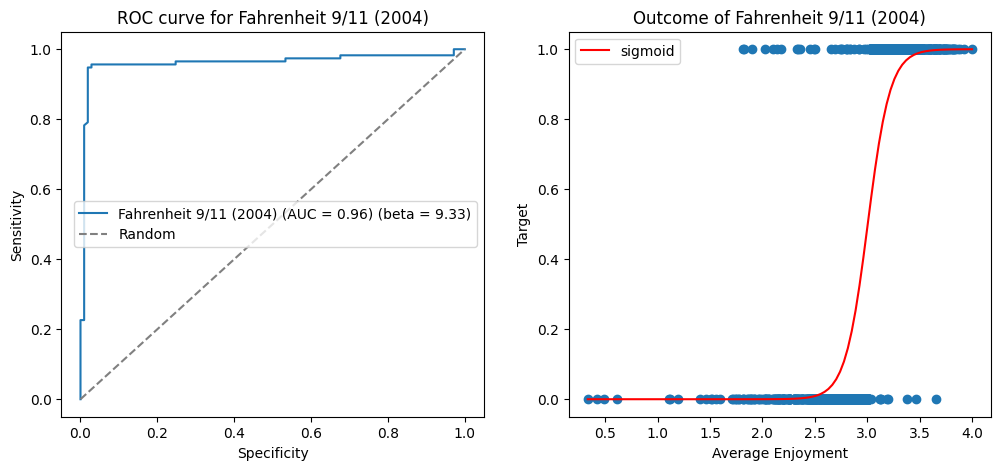

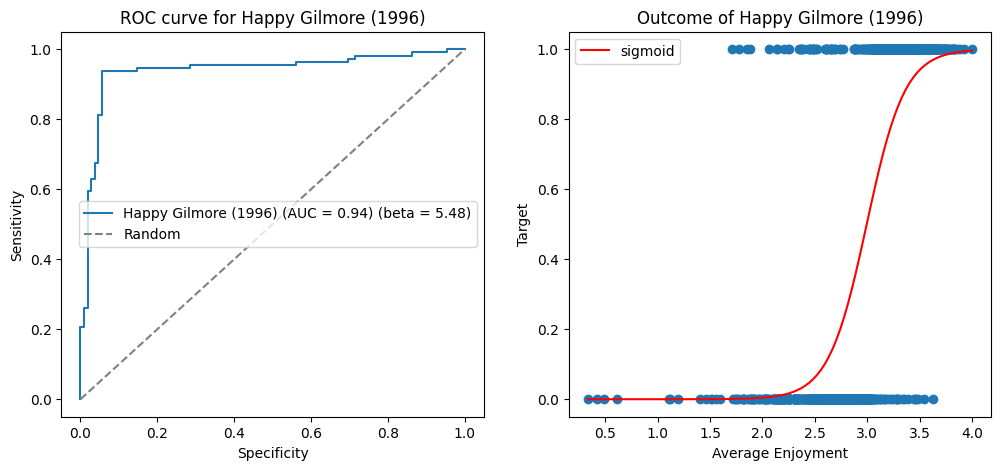

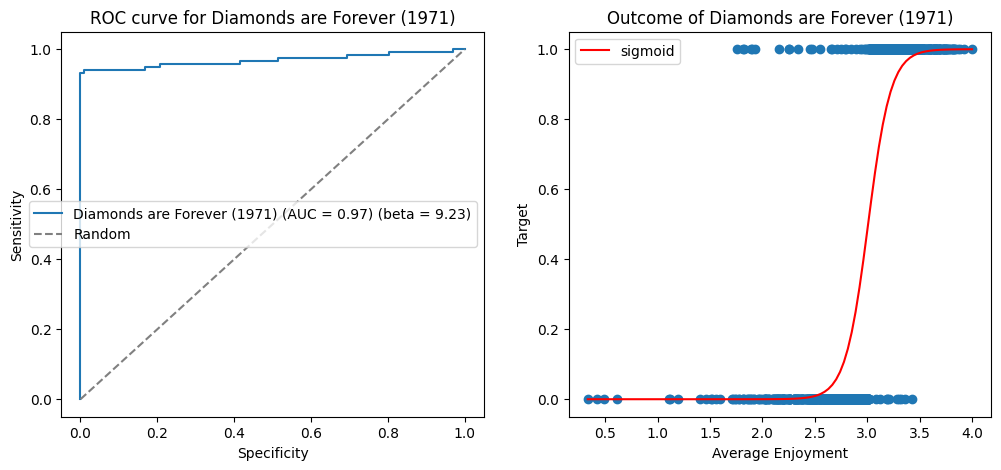

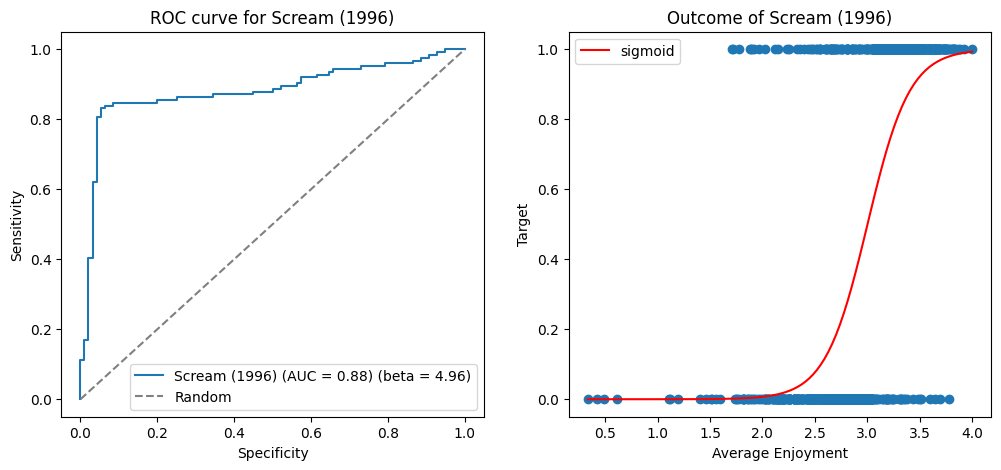

In [10]:
for m in middle_movies:
  # median split
  imputed_movie_ratings['target'] = np.where(imputed_movie_ratings[m] > imputed_movie_ratings[m].median(), 1, 0)

  # merge to drop nan
  merged = pd.merge(df['avg_enj'], imputed_movie_ratings['target'], left_index=True, right_index=True, how='left').dropna(axis=0)

  # assign X and y
  X = merged['avg_enj'].values.reshape(-1, 1)
  y = merged['target'].values

  # train test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # logistic regression
  model = LogisticRegression(class_weight='balanced')

  # hyperparameter tuning
  grid_search = GridSearchCV(estimator = model, param_grid = param_grid, scoring="accuracy")
  grid_search.fit(X_train, y_train)
  best_params = grid_search.best_params_
  print(best_params)

  # test using best model
  best_model = grid_search.best_estimator_
  # best_model.fit(X_train, y_train)
  y_pred = best_model.predict_proba(X_test)[:, 1]
  # calculate AUC
  auc = roc_auc_score(y_test, y_pred)
  # report betas
  betas = best_model.coef_[0][0]

  # separate subplots for each movie
  fig, (roc_ax, decision_boundary_ax) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

  # Plot ROC curve
  fp, tp, _ = roc_curve(y_test, y_pred)
  roc_ax.plot(fp, tp, label=f'{m} (AUC = {auc:.2f}) (beta = {betas:.2f})')
  roc_ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
  roc_ax.set_xlabel('Specificity')
  roc_ax.set_ylabel('Sensitivity')
  roc_ax.set_title(f'ROC curve for {m}')
  roc_ax.legend()

  # plot outcome
  decision_boundary_ax.scatter(X, y)
  x_values = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
  y_values = 1 / (1 + np.exp(-(best_model.coef_[0][0] * x_values + best_model.intercept_[0])))
  decision_boundary_ax.plot(x_values, y_values, color='red', label='sigmoid')

  decision_boundary_ax.set_xlabel('Average Enjoyment')
  decision_boundary_ax.set_ylabel('Target')
  decision_boundary_ax.set_title(f'Outcome of {m}')
  decision_boundary_ax.legend()

plt.show()